## Importing the libraries

In [80]:
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## json Request from API

In [81]:
HOST = 'https://api.meteo.lt/v1'
r = requests.get(HOST+'/places/vilnius/forecasts/long-term')
json = r.json()

In [82]:
time_stamp = 'Forecast_at_' + datetime.now().strftime("%Y_%m_%d_%H_%M") + '.csv'
print(time_stamp)

Forecast_at_2024_05_24_12_42.csv


## Converting json to dataframe

In [83]:
dataset = pd.DataFrame.from_dict(json['forecastTimestamps'])

## Checking for NaN values

In [84]:
dataset.isnull().values.any()

True

In [85]:
dataset.isnull().sum()

forecastTimeUtc         0
airTemperature          0
feelsLikeTemperature    0
windSpeed               0
windGust                0
windDirection           0
cloudCover              0
seaLevelPressure        0
relativeHumidity        4
totalPrecipitation      0
conditionCode           0
dtype: int64

## Saving dataframe to .csv file

In [86]:
dataset.to_csv(time_stamp, index=False)

## Plotting dataframe

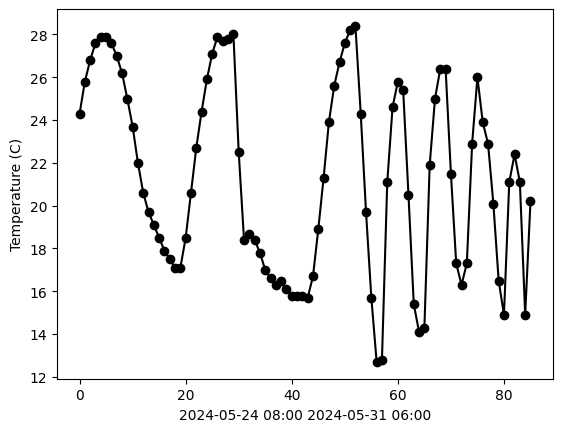

In [87]:
plt.plot(dataset['forecastTimeUtc'].index[:], dataset.iloc[:,1].values, color='black')
plt.scatter(dataset['forecastTimeUtc'].index[:], dataset.iloc[:,1].values, color='black')
plt.xlabel(dataset.iloc[0,0][0:-3] + " " + dataset.iloc[-1,0][0:-3])
plt.ylabel('Temperature (C)')
plt.show()

## Filtering dataframe by hour

In [88]:
# data_by_hour = dataset[dataset['forecastTimeUtc'].str.contains('00:00:00')]

In [89]:
# plt.plot(data_by_hour['forecastTimeUtc'].index[:56], data_by_hour['airTemperature'], color='red')
# plt.xlabel(dataset.iloc[0,0][0:11] + dataset.iloc[-1,0][0:10])
# plt.ylabel('Temperature (C)')
# plt.show()

## Splitting dataframe to X and y dataframes

In [90]:
X = dataset.iloc[:, 3:].values
y = dataset.iloc[:,1].values

In [91]:
y = y.reshape(len(y),1)

## Encoding categorical data

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

## Filling missing dataframe values

In [93]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer.fit(X)
X = imputer.transform(X)

## Splitting the dataset into the Training set and Test set

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## Feature Scaling

In [95]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)

## Training the Support Vector Regression model on the Training set

In [96]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

C:\Users\ggriu\Desktop\PTU18Notebooks\venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

## Predicting the Test set results

In [97]:
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)).reshape(-1,1))
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[22.85 26.  ]
 [25.07 24.3 ]
 [18.71 21.5 ]
 [23.16 22.7 ]
 [19.19 20.6 ]
 [14.72 12.7 ]
 [25.42 23.7 ]
 [18.53 17.1 ]
 [27.39 27.9 ]
 [23.73 25.  ]
 [18.38 25.4 ]
 [14.46 14.1 ]
 [24.14 24.3 ]
 [17.71 17.3 ]
 [16.94 20.5 ]
 [17.85 21.9 ]
 [19.71 18.4 ]
 [18.65 20.1 ]
 [19.9  19.7 ]
 [18.42 16.3 ]
 [22.1  22.  ]
 [24.7  22.5 ]
 [15.92 15.8 ]
 [22.65 27.8 ]
 [26.65 25.  ]
 [13.83 14.3 ]
 [27.48 27.9 ]
 [16.61 16.1 ]
 [22.82 18.4 ]]


## Visualising the Support Vector Regression results with dataframe results

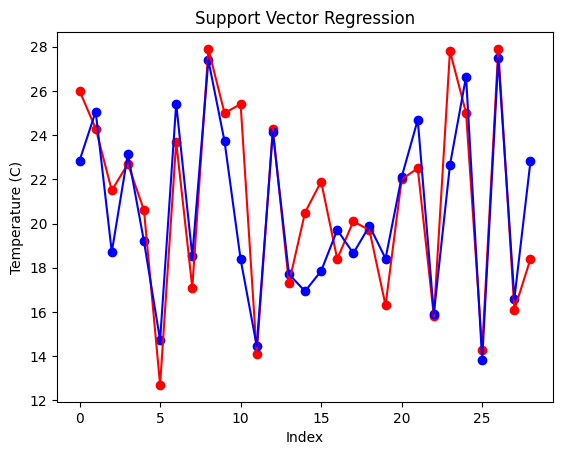

In [98]:
plt.scatter(dataset.index[0:len(y_test)], y_test, color = 'red')
plt.scatter(dataset.index[0:len(y_test)], y_pred, color = 'blue')
plt.plot(dataset.index[0:len(y_test)], y_test, color = 'red')
plt.plot(dataset.index[0:len(y_test)], y_pred, color = 'blue')
plt.title('Support Vector Regression')
plt.xlabel('Index')
plt.ylabel('Temperature (C)')
plt.show()

## Evaluating the Model Performance

In [99]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6765414457365057